# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Обзор данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
# Открываем файл и выводим первые 5 строк для ознакомления
try:
    data = pd.read_csv('./datasets/real_estate_data.csv', sep='\t')
except:
    print('Problem with local folder!')
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
#Получаем общую информацию о столбцах и значениях
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


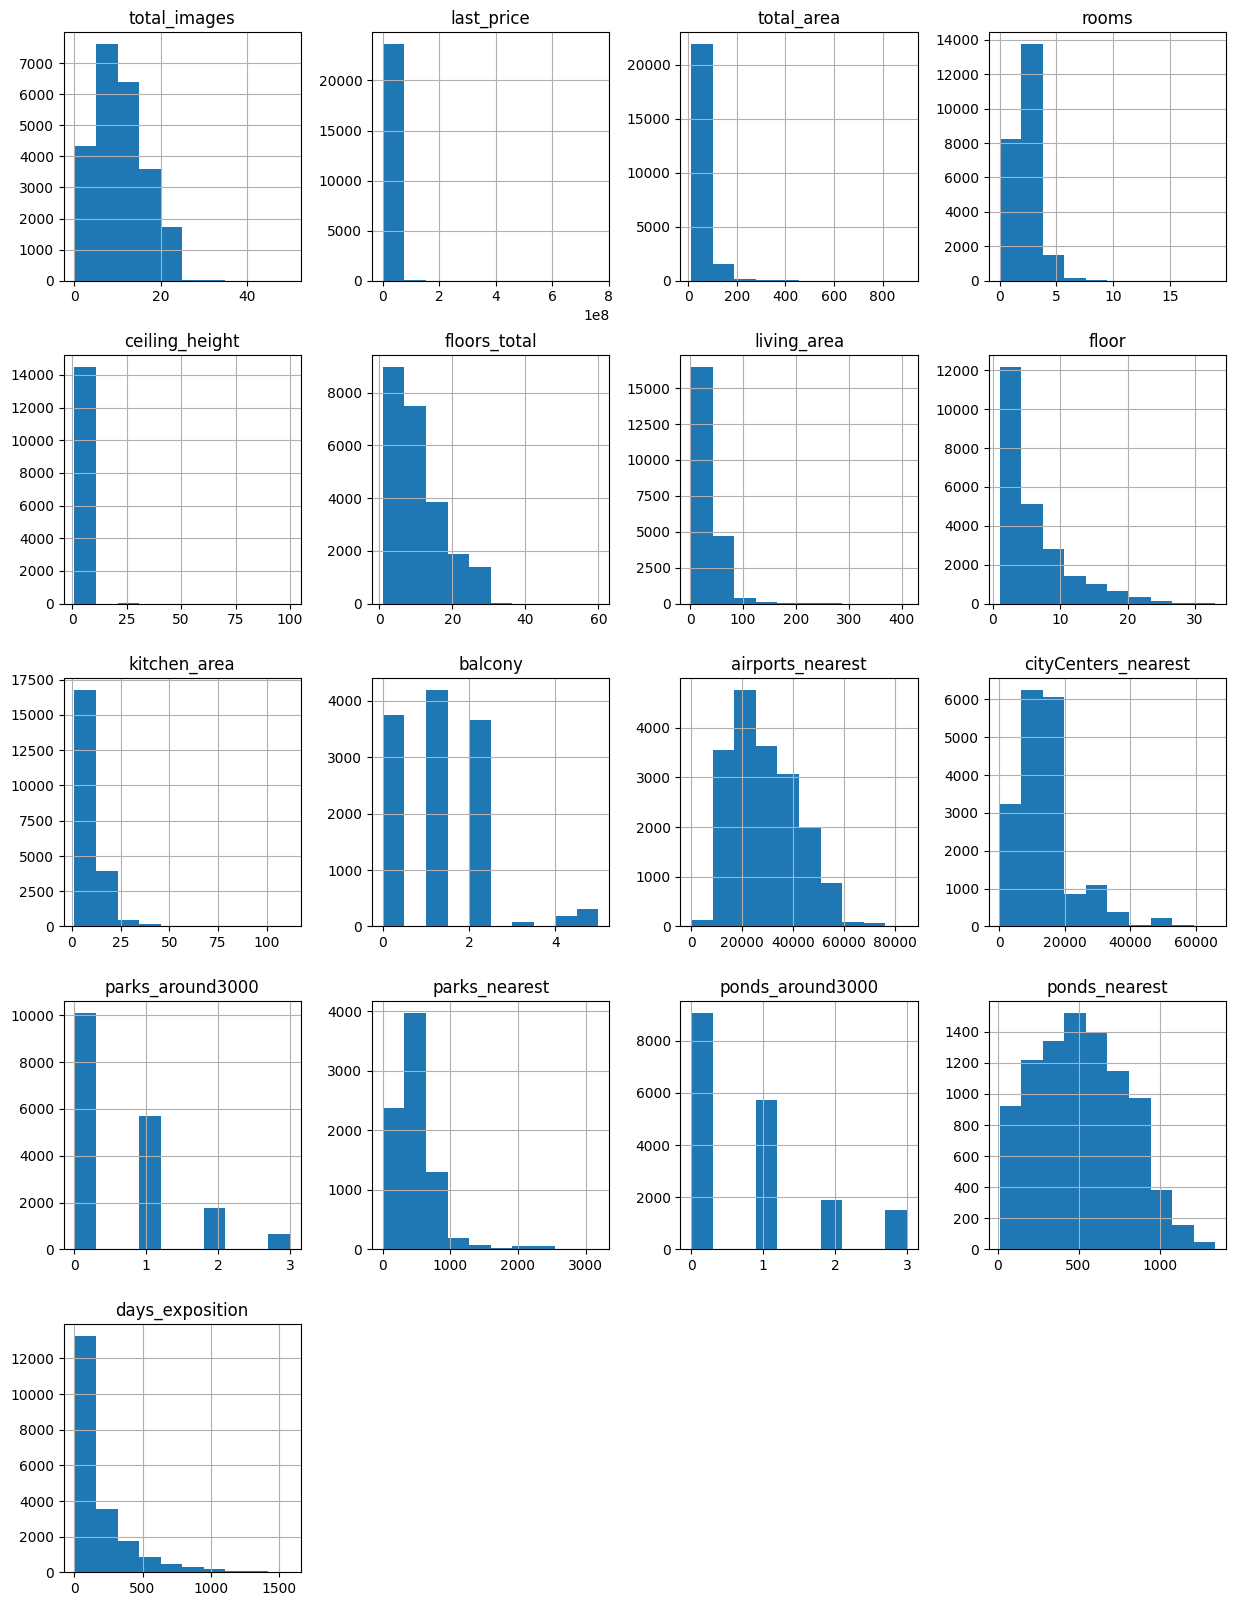

In [5]:
#Строим гистограммы распределения
data.hist(figsize=(15,20));

**Вывод**

Всего записей в выборке 23699, на этапе предобработки данных необходимо:
- Привести названия столбцов в единый вид;
- Избавиться от пропусков в данных (заменить их или исключить часть данных из выборки);
- Избавиться от выбросов данных;
- Избавиться от дубликатов в выборке;
- Изменить типы данных в столбцах в необходимый.

**Описание данных**
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

### Предобработка данных

#### Названия столбцов

Сначала поправим название столбцов, в данном случае cityCenters_nearest использует CamelCase исправим на snake_case.
Аргумент inplace изменит сам DataFrame, а не вернет копию

In [6]:
data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### Пропуски в данных

Для дальнейшей работы необходимо определить наличие и количество пропусков и заполнить их или избавиться от таких данных. Для начала определим количество пропусков в каждом столбце.

In [7]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски наблюдаются в следующих столбцах:

- `ceiling_height` (9195 пропусков): вероятно, люди не указали высоту потолков, пропуски **заменим на медиану**
- `floors_total` (86 пропусков): скорее всего, люди не указали общее количество этажей, количество этажей как правило имеет определенный набор, в основном встречаются этажи 5, 9, 16, 24, 32 этажа, поэтому пропуски **заменим на часто встречающиеся значения в выборке**
- `living_area` (1903 пропуска): вероятно, пропуски связаны с тем, что люди не считают жилую площадь помещения или в форме записи нет такой ячейки, потому что пропусков в общей площади нет, такие **данные оставляем**
- `is_apartment` (20924 пропуска): количество пропусков равно 88%, вероятно, люди не указывают данный пункт, так как недвижимиость просто жилая, пропуски можно **заменить на False**
- `kitchen_area` (2278 пропуска): аналогично living_area, такие **данные оставляем**
- `balcony` (11519 пропусков): возможно, количество балконов не указано, потому что их нет, поэтому **заменим пропуски нулями**
- `locality_name` (49 пропусков): количество пропусков мало, **заменим их на 'unknown'**
- `airports_nearest` (5542 пропусков): эти данные получены автоматически из геосервисов, проблема техническая или аэропортов поблизости нет, **данные оставляем**
- `city_centers_nearest` (5519 пропусков): странно, что здесь пропуски, поскольку у любого населенного пункта есть центр, вероятно проблема техническая, такие **данные оставляем**
- `parks_around3000` (5518 пропусков): вероятно, проблема в картографиеских данных или парки в радиусе 3 км отсутствуют, пропуски **заменим на 0**
- `parks_nearest` (15620 пропусков): техническая проблема или парки слишком далеко, **данные оставляем**
- `ponds_around3000` (5518 пропусков): количество совпадает с `parks_around3000`, пропуски **заменим на 0**
- `ponds_nearest` (14589 пропусков): техническая проблема, **данные оставляем**
- `days_exposition` (3181 пропуск): или объявление еще не снято с продажи или это техническая ошибка

##### Столбец `ceiling_height`

Заменим пропуски данных на медиану

In [8]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


##### Столбец `floors_total`

Определим наиболее часто встречаемые вариации этажей и заменим пропуски на одно из этих значений, если оно меньше или равно ему. Для проверки выведем сумму пропусков в этом столбце.

In [9]:
print(f"Пропусков до: {data['floors_total'].isna().sum()}")
unique_floors_dict = dict(data['floors_total'].value_counts().sort_values(ascending=False).head(5))
unique_floors_list = sorted(list(unique_floors_dict.keys()))
unique_floors_list
for floor in unique_floors_list:
    data.loc[(data['floors_total'].isna()) & (data['floor'] <= floor), 'floors_total'] = floor
#data.dropna(subset=['floors_total'], inplace=True)
print(f"Пропусков после: {data['floors_total'].isna().sum()}")

Пропусков до: 86
Пропусков после: 17


Количество пропусков в данном столбце стало меньше и в масштабах в выборки является незначительным, остальные пропуски оставляем.

##### Столбец `is_apartment`

Заменим пропуски на False

In [10]:
data['is_apartment'].fillna(False, inplace=True)
data['is_apartment'].isna().sum()

0

##### Столбец `balcony`

Заменим пропуски на 0

In [11]:
data['balcony'].fillna(0, inplace=True)
data['balcony'].isna().sum()

0

##### Столбец `locality_name`

Заменим пропуски на 'unknown'

In [12]:
data['locality_name'].fillna('unknown', inplace=True)
data['locality_name'].isna().sum()

0

##### Столбец `parks_around3000`

Заменим пропуски на 0

In [13]:
data['parks_around3000'].fillna(0, inplace=True)
data['parks_around3000'].isna().sum()

0

##### Столбец `ponds_around3000`

Заменим пропуски на 0

In [14]:
data['ponds_around3000'].fillna(0, inplace=True)
data['ponds_around3000'].isna().sum()

0

Мы избавились от части пропусков, оценить разницу можно ниже.

In [15]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               17
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
city_centers_nearest     5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Выбросы данных

##### Столбец `ceiling_height`

Пропуски мы заменили, но при этом имеется очень много вбросовых значений в столбце `ceiling_height`. Вероятно, некоторые значения вызваны тем, что запятая у числе стоит не там, явные тому подтверждения - это высоты 27.0 и 27.5. Необходимо разделить эти высоты на 10, чтобы привести это все в репрезентативный вид.

In [16]:
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = data['ceiling_height'] / 10
data['ceiling_height'].describe()

count    23699.000000
mean         2.698721
std          0.253208
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

#### Дубликаты

##### Явные дубликаты

In [17]:
data.duplicated().sum()

0

##### Неявные дубликаты

Явных дубликатов не обнаружено, проверим выборку на неявные. Такие дубликаты могут встретиться в столбце `locality_name`. Для начала выведем уникальные значения данного столбца.

In [18]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Заменим буквы "ё" на "е" и также исключим из названий информацию о статусе населенного пункта, поскольку в данном исследовании это не играет важной роли.

In [19]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е').replace(
                                                                    ['поселок ','при железнодорожной станции ', 'платформа ',
                                                                     'садоводческое некоммерческое товарищество ',
                                                                     'садовое товарищество ', 'станции ', 'село ', 
                                                                     'пансионат ', 'городского типа ', 'деревня ',
                                                                     'городской '], '', regex=True)


#### Типы данных

Следующим шагом следует разобраться с типами данных в столбцах. Изменять тип данных необходимо для комфортной работы с этими столбцами (например, дата) или же для сокращения используемой памяти (например, количество этажей не может быть дробным).

Столбцы, которые необходимо рассмотреть:
- `total_images` int64 -> uint8 (Нет необходимости в таком количестве памяти)
- `last_price` float64 -> int64 (Нет необходимости в таком количестве памяти, да и такое представление более удобное)
- `first_day_exposition` object -> datetime(Более удобное представление)
- `rooms` int64 -> uint8 (Нет необходимости в таком количестве памяти)
- `floor` int64 -> int16 (Нет необходимости в таком количестве памяти)
- `is_apartment` object -> bool (Корректное представление данных)
- `balcony` float64 -> uint8 (Нет необходимости в таком количестве памяти)
- `parks_around3000` float64 -> uint8 (Нет необходимости в таком количестве памяти)
- `ponds_around3000` float64 -> uint8 (Нет необходимости в таком количестве памяти)

In [20]:
data['total_images'] = data['total_images'].astype('uint8')
data['last_price'] = data['last_price'].astype('int64')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['rooms'] = data['rooms'].astype('uint8')
data['floor'] = data['floor'].astype('int16')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('uint8')
data['parks_around3000'] = data['parks_around3000'].astype('uint8')
data['ponds_around3000'] = data['ponds_around3000'].astype('uint8')

#### Вывод

В ходе предобработки данных был проделан следующий ряд работ:
- Изменение названия столбца в DataFrame для общего вида;
- Заполнение пропусков в столбцах, где это возможно и не повлекло бы за собой заметных искажений результатов;
- Обработка выбросов данных в столбце с высотой потолков;
- Обработка дубликатов в названиях населнных пунктов;
- Изменение типов данных для более комфортной и быстрой работы с данными.

Таким образом, после проведения предобработки данных, можно приступать к исследованию данных.

### Добавление новых столбцов

In [21]:
#Функция для определения типа этажа
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

#Цена за один квадратный метр
data['price_square_meter'] = data['last_price'] / data['total_area'].round(2)
#День недели, в который было опубликовано объявление
data['week_day_exposition'] = data['first_day_exposition'].dt.weekday
#Месяц, в который было опубликовано объявление
data['month_exposition'] = data['first_day_exposition'].dt.month
#Год, в который было опубликавно объявление
data['year_exposition'] = data['first_day_exposition'].dt.year
#Тип этажа
data['floor_type'] = data.apply(floor_type, axis=1)
# Расстояние до центра города в км
data['city_center_nearest_km'] = (data['city_centers_nearest'] / 1000).round()

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,week_day_exposition,month_exposition,year_exposition,floor_type,city_center_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,False,False,11.0,2,Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.65,14.0,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой,8.0


### Исследовательский анализ данных

#### Анализ рапределений

##### Анализ общей площади

In [22]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

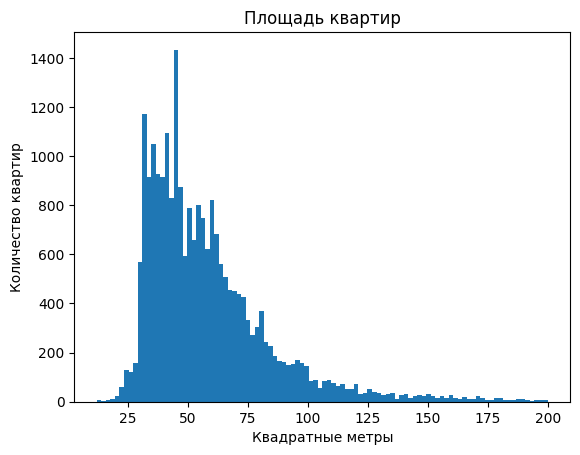

In [23]:
plt.hist(data['total_area'], bins=100, range=(12,200))
plt.title('Площадь квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

**Вывод**

Большая часть объектов недвижимости имеет распределение в районе 40-69 кв.м. Присутствуют и очень большие значения, но медиана находится на уровне 52 кв.м.

##### Анализ жилой площади

In [24]:
data['living_area'].describe()

count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

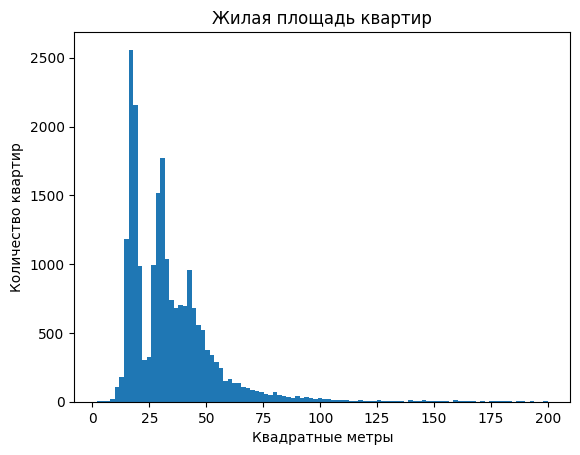

In [25]:
plt.hist(data['living_area'], bins=100, range=(2,200))
plt.title('Жилая площадь квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

**Вывод**

По графику явно выражены два пика на уровне 20 и 30 кв.м, при этом на уровне 25 кв.м происходит спад количества квартир.

##### Анализ площади кухни

In [26]:
data['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

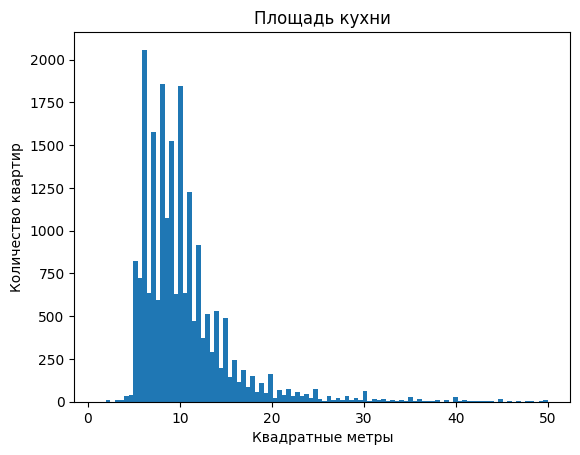

In [27]:
plt.hist(data['kitchen_area'], bins=100, range=(1,50))
plt.title('Площадь кухни')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()

**Вывод**

Наиболее часто встречаемая площадь кухни находится в пределах 7-12 кв.м.

##### Анализ цены объекта

In [28]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

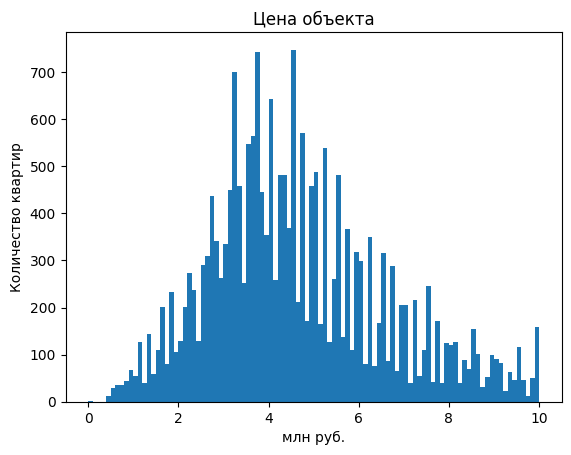

In [29]:
plt.hist(data['last_price'] / 1_000_000, bins=100, range=(0,10))
plt.title('Цена объекта')
plt.xlabel('млн руб.')
plt.ylabel('Количество квартир')
plt.show()

**Вывод**

Наиболее часто встречаемая цена квартиру находится в пределах 3-5 млн руб.

##### Анализ количества комнат

In [30]:
data['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

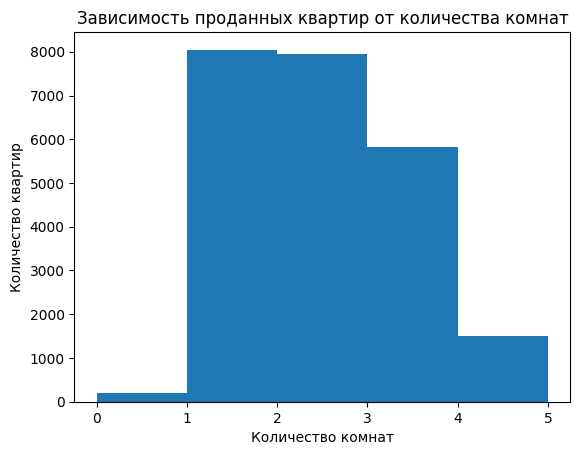

In [31]:
plt.hist(data['rooms'], bins=5, range=(0, 5))
plt.title('Зависимость проданных квартир от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()

**Вывод**

Большая часть объявлений содержит объекты с количеством комнат от 1 до 3.

##### Анализ высоты потолков

In [32]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.698721
std          0.253208
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

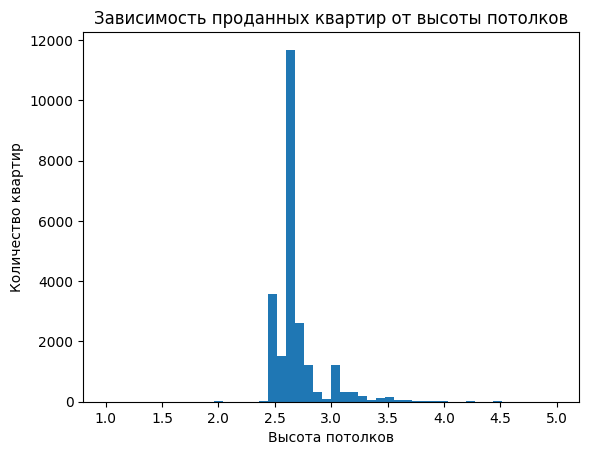

In [33]:
plt.hist(data['ceiling_height'], bins=50, range=(1, 5))
plt.title('Зависимость проданных квартир от высоты потолков')
plt.xlabel('Высота потолков')
plt.ylabel('Количество квартир')
plt.show()

**Вывод**

Большая часть квартир имеет высоту потолков 2,6-2,8 метров, то есть стандартные высоты.

##### Анализ типа этажа

In [34]:
data['floor_type'].describe()

count      23699
unique         3
top       другой
freq       17421
Name: floor_type, dtype: object

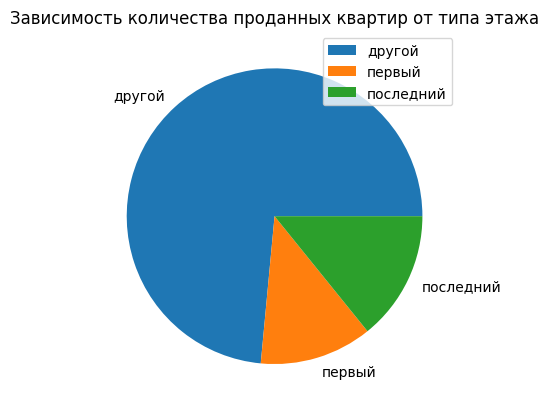

In [35]:
data.pivot_table(index='floor_type',values='last_price',aggfunc='count').plot.pie(y='last_price', label='', title='Зависимость количества проданных квартир от типа этажа')
plt.show()

**Вывод**

Меньше всего квартир на первом и последнем этажах, следовательно, они скорее всего будут дешевле других, так как люди больше предпочитают квартиры на средних этажах.

##### Анализ общего количества этажей в доме

In [36]:
data['floors_total'].describe()

count    23682.000000
mean        10.668145
std          6.591705
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

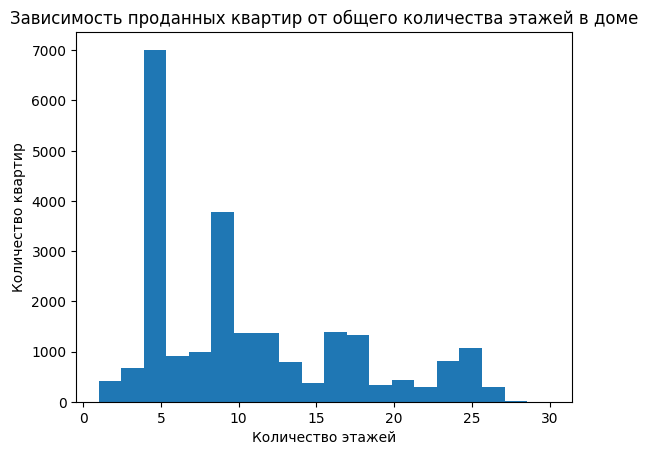

In [37]:
plt.hist(data['floors_total'], bins=20, range=(1, 30))
plt.title('Зависимость проданных квартир от общего количества этажей в доме')
plt.xlabel('Количество этажей')
plt.ylabel('Количество квартир')
plt.show()

**Вывод**

Больше всего проданных квартир заметно на домах с 5,9 и 16 этажами, судя по всему дома данной конфигурации преобладают в регионе при чем больше всего домов именно с 5 этажами.

##### Анализ расстояния до центра города в метрах

In [38]:
data['city_centers_nearest'].describe()

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

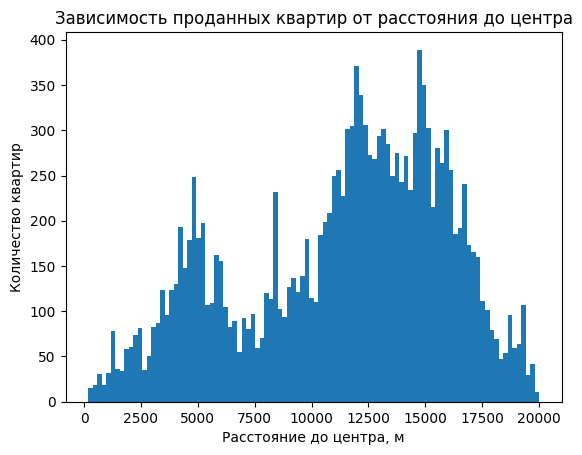

In [39]:
plt.hist(data['city_centers_nearest'], bins=100, range=(181, 20_000))
plt.title('Зависимость проданных квартир от расстояния до центра')
plt.xlabel('Расстояние до центра, м')
plt.ylabel('Количество квартир')
plt.show()

**Вывод**

Заметно два всплеска на 5 км и на 11-16 км. Вероятно, 5 км - это квартиры в центре, а другие - квартиры в спальных районах.

##### Анализ расстояния до ближайшего парка

In [40]:
data['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

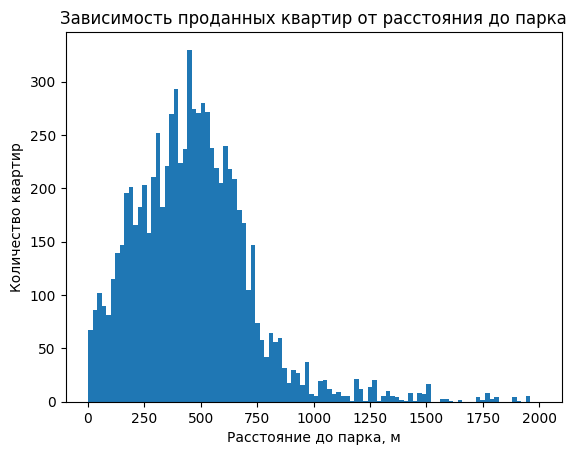

In [41]:
plt.hist(data['parks_nearest'], bins=100, range=(1, 2_000))
plt.title('Зависимость проданных квартир от расстояния до парка')
plt.xlabel('Расстояние до парка, м')
plt.ylabel('Количество квартир')
plt.show()

**Вывод**

Наибольшее количество квартир имеют парк в пределах 300-600 м.

##### Общий вывод

Исходя из вышесказанных выводов, можно составить среднестатистичекий проданный объект недвижимости - это 2-х комнатная квартира в спальном районе, находящаяся на средних этажах и имеющая цену около 4 млн. Предполгаю, это пригодится для определения мошенничества или ошибок в данных при формировании цены.

#### Анализ скорости продажи

In [42]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

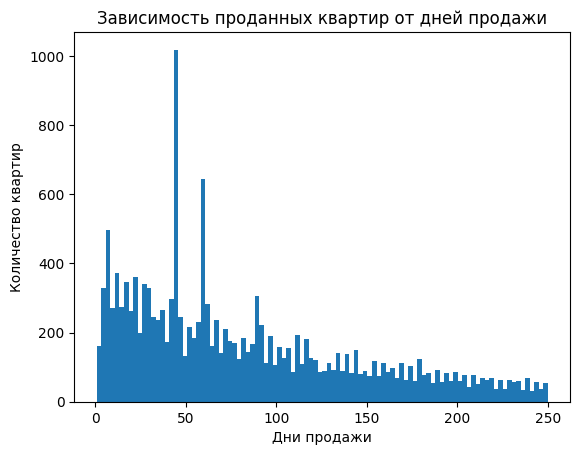

In [43]:
plt.hist(data['days_exposition'], bins=100, range=(1, 250))
plt.title('Зависимость проданных квартир от дней продажи')
plt.xlabel('Дни продажи')
plt.ylabel('Количество квартир')
plt.show()

**Вывод**

Среднее значение количества дней продажи квартры составляет 180 дней, в то время как медианное значение - 95 дней, поэтому в данном случае лучше применять медианное значение, так как оно более устойчиво к выбросам. Действительно, основные значения мы видим между 25 и 75 процентилями, таким образом, среднестатистическое время продажи квартиры составляет от 1.5 до 7 месяцев, затем начинается уже спад продаж. В основном же, продажи квартир составляют 3 месяца.

#### Анализ зависимостей стоимости квартиры от других показателей

Сделаем предвариетельную таблицу для оценки корреляция между различными показателями.

In [44]:
test = data.pivot_table(index='floor', values=['last_price','total_area','living_area','kitchen_area','rooms']).corr()
test.style.background_gradient(cmap='RdYlGn')

,kitchen_area,last_price,living_area,rooms,total_area
kitchen_area,1.000000,0.361686,0.106517,0.094420,0.411305
last_price,0.361686,1.000000,0.655849,0.442449,0.738972
living_area,0.106517,0.655849,1.000000,0.897739,0.923741
rooms,0.094420,0.442449,0.897739,1.000000,0.811538
total_area,0.411305,0.738972,0.923741,0.811538,1.000000


Поскольку выяснилось, что в столбцах цены и площадей присутствуют вбросовые значения, было принято решение избавиться от слишком крупных значений с помощью межквартильного размаха.

In [45]:
# Функция для подсчёта границ с учетом 1.5 размаха
def quartile_range(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    dfq = df.loc[(df[column] < q3 + 1.5*iqr) & (df[column] > q1 - 1.5*iqr), column]
    return dfq
# Столбцы с выбросами
list_features = ['last_price', 'total_area', 'kitchen_area', 'living_area', 'days_exposition', 'ceiling_height', 'rooms']
for col in list_features:
    data[col] = quartile_range(data, col)
# Снова проверим значения
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,week_day_exposition,month_exposition,year_exposition,city_center_nearest_km
count,23699.000000,2.163800e+04,22459.000000,23504.000000,20744.000000,23682.000000,21023.000000,23699.000000,20219.000000,23699.000000,18157.000000,18180.000000,23699.000000,8079.000000,23699.000000,9110.000000,18849.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,18180.000000
mean,9.858475,4.839970e+06,54.364907,2.030250,2.631250,10.668145,31.552247,5.892358,9.504662,0.591080,28793.672193,14191.277833,0.469049,490.804555,0.590911,517.980900,128.753886,9.942166e+04,2.569307,6.400101,2017.367146,14.184818
std,5.682529,2.217341e+06,19.385325,0.973667,0.081318,6.591705,13.941065,4.885249,3.125573,0.959298,12630.880622,8608.386210,0.748534,342.317995,0.883999,277.720643,121.531193,5.030680e+04,1.789082,3.491561,1.039771,8.616194
min,0.000000,1.219000e+04,12.000000,0.000000,2.460000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.118349e+02,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.300000e+06,39.400000,1.000000,2.600000,5.000000,18.400000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,41.000000,7.658547e+04,1.000000,3.000000,2017.000000,9.000000
50%,9.000000,4.400000e+06,50.100000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26726.000000,13098.500000,0.000000,455.000000,0.000000,502.000000,85.000000,9.500000e+04,3.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.000000e+06,65.600000,3.000000,2.650000,16.000000,41.000000,8.000000,11.100000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,183.000000,1.142563e+05,4.000000,10.000000,2018.000000,16.000000
max,50.000000,1.189440e+07,114.600000,5.000000,2.850000,60.000000,77.800000,33.000000,19.450000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,512.000000,1.907500e+06,6.000000,12.000000,2019.000000,66.000000


Снова создадим сводную таблицу с корреляциями и оценим насколько изменились данные.

In [46]:
test = data.pivot_table(index='floor', values=['last_price','total_area','living_area','kitchen_area','rooms']).corr()
test.style.background_gradient(cmap='RdYlGn')

,kitchen_area,last_price,living_area,rooms,total_area
kitchen_area,1.000000,0.418146,-0.228340,-0.253448,0.236823
last_price,0.418146,1.000000,0.725857,0.551637,0.905255
living_area,-0.228340,0.725857,1.000000,0.901722,0.917353
rooms,-0.253448,0.551637,0.901722,1.000000,0.786100
total_area,0.236823,0.905255,0.917353,0.786100,1.000000


Прослеживается явная зависиомсть цены продажи от общей площади, и соответственно, жилой площади. Низкая корреляция у цены с площадью кухни и количеством комнат.
Теперь построим графики зависимости цены продажи от следующих показателей:

- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

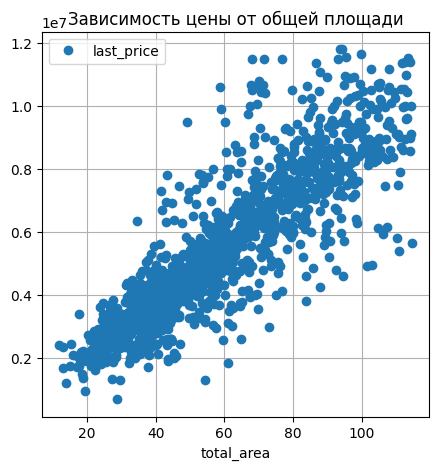

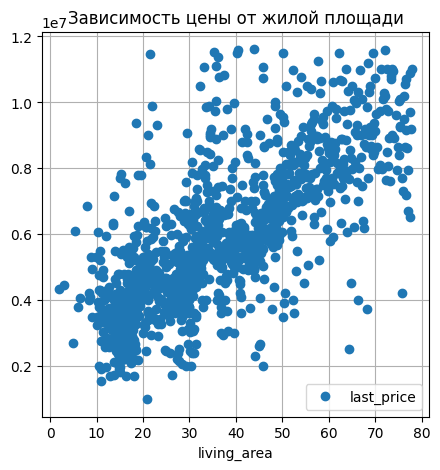

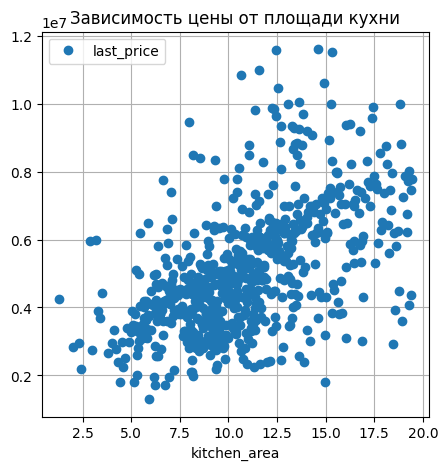

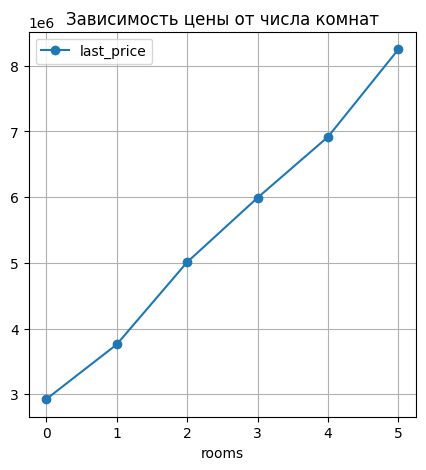

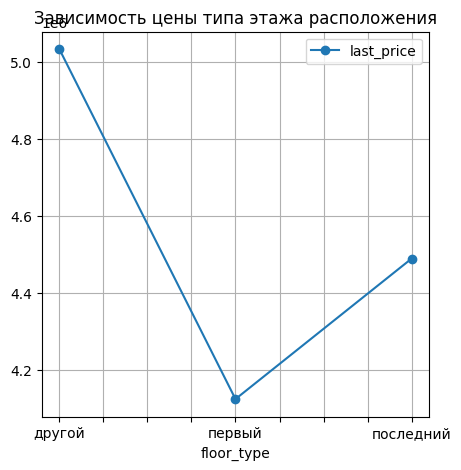

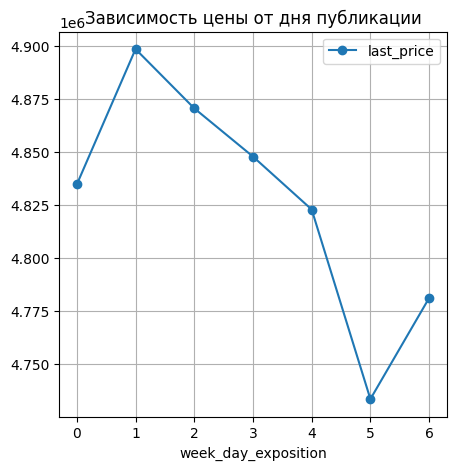

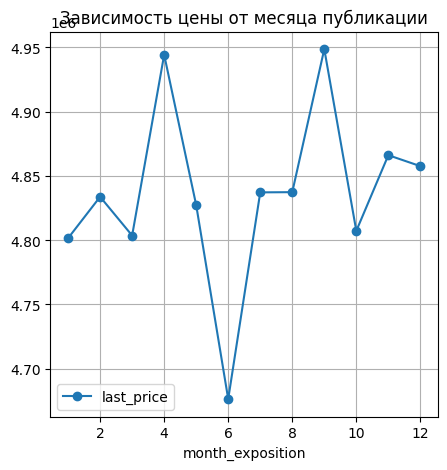

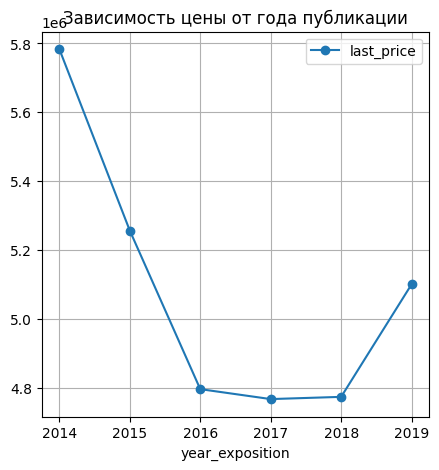

In [47]:
#Зависимость цены от общей площади
data.pivot_table(index='total_area', values='last_price').plot(grid=True, style='o', figsize=(5, 5))
plt.title('Зависимость цены от общей площади')
plt.show()

#Зависимость цены от жилой площади
data.pivot_table(index='living_area', values='last_price').plot(grid=True, style='o', figsize=(5, 5))
plt.title('Зависимость цены от жилой площади')
plt.show()

#Зависимость цены от площади кухни
data.pivot_table(index='kitchen_area', values='last_price').plot(grid=True, style='o', figsize=(5, 5))
plt.title('Зависимость цены от площади кухни')
plt.show()

#Зависимость цены от числа комнат
data.pivot_table(index='rooms', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))
plt.title('Зависимость цены от числа комнат')
plt.show()

#Зависимость цены типа этажа расположения
data.pivot_table(index='floor_type', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))
plt.title('Зависимость цены типа этажа расположения')
plt.show()

#Зависимость цены от дня публикации
data.pivot_table(index='week_day_exposition', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))
plt.title('Зависимость цены от дня публикации')
plt.show()

#Зависимость цены от месяца публикации
data.pivot_table(index='month_exposition', values='last_price') .plot(grid=True, style='o-', figsize=(5, 5))
plt.title('Зависимость цены от месяца публикации')
plt.show()

#Зависимость цены от года публикации
data.pivot_table(index='year_exposition', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))
plt.title('Зависимость цены от года публикации')
plt.show()

**Выводы**

По полученным сводным таблицам и графикам можно сделать следующие выводы:

- Цена очень сильно зависит от общей площади недвижимости.
- В большей степени цена зависит от жилой площади недвижимости, нежели от площади кухни.
- Цена зависит от количества комнат, но в меньшей степени, чем от общей площади. Вероятно, это связано с тем, что квартиры с меньшим количеством комнат, могут иметь близкую по размерам площадь.
- Цена зависит от этажа недвижимости, так первый этаж является самым дешевым, последний чуть дороже, а промежуточные этажи наиболее дорогие.
- Не прослеживается никакой зависимости между месяцом, годом публикации и ценой.

#### Анализ цены за один квадратный метр

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов.

In [48]:
price_square_meter_table = data.pivot_table(index='locality_name', values='last_price', aggfunc='count')
price_square_meter_table = price_square_meter_table.sort_values(by='last_price', ascending=False).head(10)
price_square_meter_table.rename(columns={'last_price': 'count'}, inplace=True)
price_square_meter_table['price_square_meter'] = data.pivot_table(index='locality_name', values='price_square_meter').round(2)
price_square_meter_table.sort_values(by='price_square_meter', ascending=False)

,count,price_square_meter
locality_name,,
Санкт-Петербург,13737,114849.01
Пушкин,338,103125.82
Кудрово,470,95324.93
Парголово,327,90175.91
Мурино,590,86087.51
Шушары,440,78677.36
Колпино,336,75424.58
Гатчина,305,68746.15
Всеволожск,397,68654.47


**Вывод**

Как и ожидалось, наибольшая цена за квадратный метр в Санкт-Петербурге, вторая столица все-таки. Цены в других городах меньше за счет инфраструктуры и дальности от Санкт-Петербурга. Также можно заметить, что количество квартир на продажу в Санкт-Петербурге в разы выше, чем в других городах.

#### Анализ стоимости от удаления от центра

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23699 non-null  uint8         
 1   last_price              21638 non-null  float64       
 2   total_area              22459 non-null  float64       
 3   first_day_exposition    23699 non-null  datetime64[ns]
 4   rooms                   23504 non-null  float64       
 5   ceiling_height          20744 non-null  float64       
 6   floors_total            23682 non-null  float64       
 7   living_area             21023 non-null  float64       
 8   floor                   23699 non-null  int16         
 9   is_apartment            23699 non-null  bool          
 10  studio                  23699 non-null  bool          
 11  open_plan               23699 non-null  bool          
 12  kitchen_area            20219 non-null  float6

In [50]:
data[data['locality_name'] == 'Санкт-Петербург']['city_center_nearest_km'].describe()

count    15660.000000
mean        11.596041
std          4.863594
min          0.000000
25%          8.000000
50%         12.000000
75%         15.000000
max         29.000000
Name: city_center_nearest_km, dtype: float64

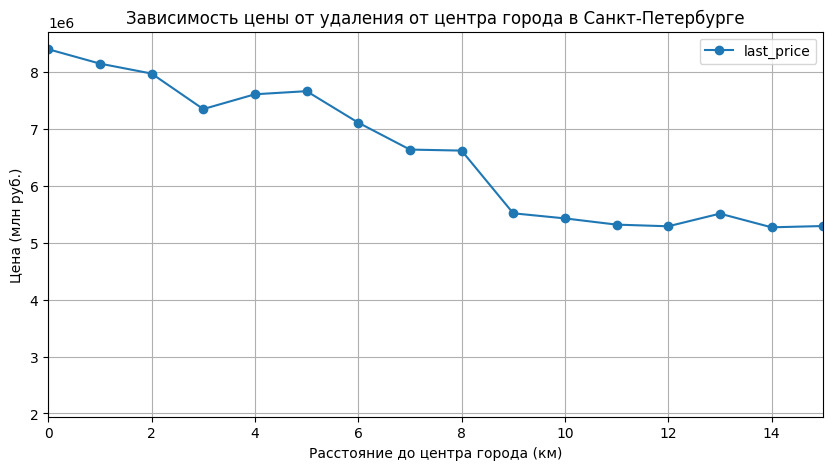

In [51]:
(
    data[data['locality_name'] == 'Санкт-Петербург']
    .pivot_table(index='city_center_nearest_km', values='last_price')
    .plot(grid=True, style='o-', xlim=(0,15), figsize=(10, 5))
)
plt.title('Зависимость цены от удаления от центра города в Санкт-Петербурге')
plt.xlabel('Расстояние до центра города (км)')
plt.ylabel('Цена (млн руб.)')
plt.show()

In [52]:
#Таблица средней стоимости квартир на разном удалении от центра
data.query('locality_name == "Санкт-Петербург" and city_center_nearest_km < 15').pivot_table(values='last_price', index='city_center_nearest_km')

,last_price
city_center_nearest_km,
0.0,8.398000e+06
1.0,8.145277e+06
2.0,7.970519e+06
3.0,7.346575e+06
4.0,7.606618e+06
5.0,7.661225e+06
6.0,7.108234e+06
7.0,6.635321e+06
8.0,6.617244e+06


**Вывод**

Исходя из полученной таблицы и графика, можно сделать вывод о том, что цена недвижимости зависит от удаления от центра: чем больше расстояние, тем дешевле. Однако, начиная с 9 км цена остается практически неизменной.

### Общий вывод

В ходе проведенного исследования был проделан следующий ряд работ и сделаны следующие выводы:

1. Открыт и изучен файл
    - Всего файл имеет 23699 записей, имеются пропуски и вбросы данных. Данные были признаны поллными и достаточными для исследования.
2. Проведена предобработка данных:
    - Было измнено название столбца `cityCenters_nearest` на `city_centers_nearest`.
    - Заполнены явные пропуски в таблице, данные были приведены к медианным значениям или к самым популярным в случае с этажностью здания.
    - Изменен тип данных в столбцах в соотвестствии с их назначением и для оптимизации памяти.
    - Были устранены вбросовые значения в высоте потолка (32 м стали 3.2 м).
    - Явных дубликатов не обнаружено. Неявные дубликаты в названиях населенных пунктов были устранены.

    - Причинами пропусков в данных могли служить следующие причины:
        - Человеческий фактор;
        - Проблемы на этапе сбора информации (нет обязательных полей);
        - Проблема с техническими расчетами (расстояние до аэропорта, прудов и т.п.)
3. Добавлены новые столбцы в таблицу с данными для дальнейшего исследования:
    - `price_square_meter` - цена квадратного метра объекта с точностью до двух знаков после запятой.
    - `week_day_exposition` - день недели публикации объявления (0 — понедельник, 1 — вторник и так далее).
    - `month_exposition` - месяц публикации объявления.
    - `year_exposition` - год публикации объявления.
    - `floor_type` - тип этажа квартиры (значения — «первый», «последний», «другой»).
    - `city_center_nearest_km` - расстояние до центра города в целых километрах.
4. Проведен исследовательский анализ данных:
    - Изучены параметры и составлен портрет среднестатистического объекта недвижимости:
        2х-комнатная квартира площадью 52 кв.м с площадью жилого помещения и кухни 30 и 9 кв.м соответственно. Находится такая квартира в спальном районе на расстоянии 13 км от центра города, на средних этажах и с высотой потолков 2.65 м. Стоимость такой квартиры находится в пределах 4.65 млн руб.
    - Проведен анализ скорости продажи квартиры:
        Медианное значение составляет 95 дней, в то время как среднее 180 дней. Быстрыми продажами можно назвать продажи, совершенные за 45 дней и менее (ниже 25 процентиля), долгими - продажи, совершенные за 233 дня и более (выше 75 процентиля).
    - Проведен анализ зависимости цены квартиры от других параметров:
        - Чем больше общая площадь квартиры, тем выше и цена, данные показатели имеют высокукю корреляцию (0.9)
        - Чем больше количество комнат, тем выше цена на квартиру. Но здесь также присутствует влияние и на общую площадь: чем больше комнат, тем больше общая площадь, и следовательно цена на квартиру. Однако, здесь корреляция все таки меньше (0.7), потому что есть квартиры с меньшим количеством комнат, но сопоставимой общей площадью.
        - Цена зависит от этажа недвижимости, так первый этаж является самым дешевым, последний чуть дороже, а промежуточные этажи наиболее дорогие.
    - Проведен анализ цены за один квадратный метр в 10 населенных пунктах с наибольшим числом объявлений:
        - Как и ожидалось, наибольшая цена за квадратный метр в Санкт-Петербурге, вторая столица все-таки. Цены в других городах меньше за счет инфраструктуры и дальности от Санкт-Петербурга. Также можно заметить, что количество квартир на продажу в Санкт-Петербурге в разы выше, чем в других городах.
    - Проведен анализ зависимости цены квартиры от удаления от центра:
         - Исходя из полученной таблицы и графика, можно сделать вывод о том, что цена недвижимости зависит от удаления от центра: чем больше расстояние, тем дешевле. Однако, начиная с 9 км цена остается практически неизменной.